# Preamble

In [1]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
EXPRS = {}

In [187]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return(run)

def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term*mult
    term_simplify(run)
    return(run)

In [129]:
# Positive constant
G, M, mp, ep, b, bp, j, mup, tm, b1_3_2, b2_3_2 = symbols("G M m_p e_p beta beta_p j mu_p tau_m b_{3/2}^{(1)}(\\alpha_0) b_{3/2}^{(2)}(\\alpha_0)", positive=True)
# Precession frequencies
om, omp = symbols("omega omega_p")
# Functions of time
ap, lp, np, a, l, pom, th, thp, alpha = symbols("a_p lambda_p n_p a lambda varpi theta theta_p alpha") 
# Positive functions of time
e = symbols("e", positive=True)
# Actions
Gam, Lam = symbols("Gamma Lambda", positive=True)
# Derivatives
dth, dthp = symbols(r"\dot\theta \dot\theta_p")

In [5]:
EXPRS[thp] =  (j + 1) * l - j * lp - omp * t
EXPRS[th] = (j + 1) * l - j * lp - pom

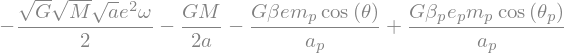

In [6]:
H_expr = - G*M/(2*a) - Rational(1,2)*sqrt(G*M*a)*e**2*om + G*mp/ap*bp*ep*cos(thp) - G*mp/ap*b*e*cos(th)
H_expr

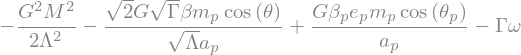

In [7]:
H = H_expr.subs(
    {
        Rational(1, 2) * sqrt(G * M * a) * e**2: Gam,
        e: sqrt(2 * Gam / Lam),
        a: Lam**2 / (G * M),
    }
)
H = term_simplify(H)
H

In [8]:
def diff(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key)*EXPRS[key].diff(var)
    return(run)

Right now, keeping ALL terms, and removing $\mathcal O(\mu_p^2)$ in the Latex document

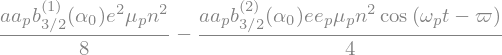

In [9]:
R = mup*n**2*a**2*Rational(1,8)*(ap/a)*b1_3_2*e**2 - mup*n**2*a**2*Rational(1,4)*(ap/a)*b2_3_2*e*ep*cos(omp*t-pom)
R

# EOMs

## $\dot \Lambda$

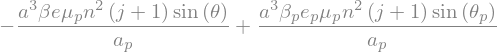

In [10]:
Lamdot = (
    -diff(H, l)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Lamdot

## $\dot n$

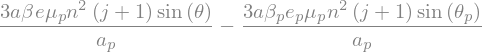

In [11]:
ndot = term_multiply(Lamdot, -3 * n**2 * a / (G * M))
ndot = (
    ndot.subs({sqrt(2 * Gam / Lam): e})
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
ndot

## $\dot a$

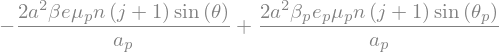

In [12]:
adot = term_multiply(Lamdot, 2/(n*a))
adot

## $\dot \Gamma$

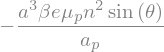

In [13]:
Gamdot = (
    diff(H, pom)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
Gamdot

## $\dot e$

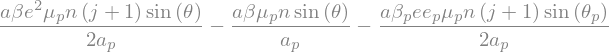

In [14]:
edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
edot = edot.subs({sqrt(2*Gam/Lam):e})
edot = edot.subs({Lam:sqrt(G*M*a)}).subs({sqrt(G*M):n*a**Rational(3,2)})
edot

## $\dot \varpi$

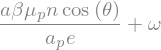

In [15]:
pomdot = (
    (-diff(H, Gam))
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)
pomdot

## $\dot \lambda$

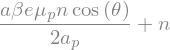

In [16]:
ldot = (
    diff(H, Lam)
    .subs(mp, mup * M)
    .subs({sqrt(Gam): sqrt(Lam / 2) * e})
    .subs({Lam: sqrt(G * M * a)})
    .subs({sqrt(G * M): n * a ** Rational(3, 2)})
)

ldot

## $\dot \theta_p$

## $\ddot\lambda$

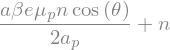

In [17]:
ldot

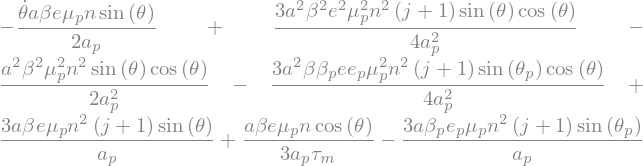

In [18]:
lddot = (
    (
        diff(ldot, th) * dth 
        +term_multiply(adot,diff(ldot, a))
        +term_multiply(edot,diff(ldot, e))
        +term_multiply(ndot,diff(ldot, n).args[0])
        +term_multiply(ndot,diff(ldot, n).args[1])
        +diff(ldot,ap)*(-2*ap/(3*tm))
    )
) 
lddot

In [19]:
#lddot = (lddot + O(mup**2)).removeO() # first order in mu_p since theres not 1/e terms
#lddot

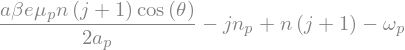

In [20]:
thpdot = term_multiply(ldot,(j+1)) - j*np - omp
thpdot

In [21]:
print(latex(thpdot))

\frac{a \beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{2 a_{p}} - j n_{p} + n \left(j + 1\right) - \omega_{p}


## $\ddot\theta_p$

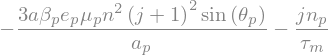

In [22]:
thpddot = term_multiply(lddot,(j+1)) - j*np/tm
thpddot.subs(b,0)

In [23]:
print(latex(thpddot.subs(a/ap,alpha**(-1))))

- \frac{\dot\theta \beta e \mu_{p} n \left(j + 1\right) \sin{\left(\theta \right)}}{2 \alpha} - \frac{j n_{p}}{\tau_{m}} + \frac{3 \beta e \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)}}{\alpha} + \frac{\beta e \mu_{p} n \left(j + 1\right) \cos{\left(\theta \right)}}{3 \alpha \tau_{m}} - \frac{3 \beta_{p} e_{p} \mu_{p} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)}}{\alpha} + \frac{3 \beta^{2} e^{2} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}} - \frac{\beta^{2} \mu_{p}^{2} n^{2} \left(j + 1\right) \sin{\left(\theta \right)} \cos{\left(\theta \right)}}{2 \alpha^{2}} - \frac{3 \beta \beta_{p} e e_{p} \mu_{p}^{2} n^{2} \left(j + 1\right)^{2} \sin{\left(\theta_{p} \right)} \cos{\left(\theta \right)}}{4 \alpha^{2}}


## $\dot\varpi_{\rm sec}$

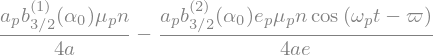

In [24]:
pomdsec = term_multiply(diff(R,e),1/(n*a**2*e))
pomdsec

## $\dot e_{\rm sec}$

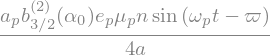

In [25]:
edsec = -diff(R,pom)/(n*a**2*e)
edsec

# Right hand side for numerical integrations

In [344]:
Eq(np,exp(-t/tm))

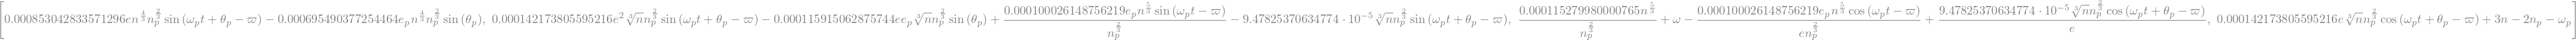

In [479]:
TMVAL = 2 * npy.pi * 1e6
convs = {}
convs = {ap: n ** Rational(2, 3) / np ** Rational(2, 3) * a, th: thp + omp * t - pom}
params = {}
params = {
    j: 2,
    mup: 5e-5,
    bp: 1.5455341716765871,
    b: 1.8956507412695471,
    #ep: 0.1,
    b1_3_2: 9.222398400061197,
    b2_3_2: 8.002091900497529,
}

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)
#params[omp] = 0
#params[om] = params[omp] * alpha0val**3.5


funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [ndot, edot + edsec, pomdot + pomdsec, thpdot]
]
funs

In [480]:
xp = [n, e, pom, thp, np, t]

In [481]:
lambdastr(xp, funs).replace("math", "npy")

'lambda n,e,varpi,theta_p,n_p,t: ([0.000853042833571296*e*n**(4/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi) - 0.000695490377254464*e_p*n**(4/3)*n_p**(2/3)*npy.sin(theta_p), 0.000142173805595216*e**2*n**(1/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi) - 0.000115915062875744*e*e_p*n**(1/3)*n_p**(2/3)*npy.sin(theta_p) + 0.000100026148756219*e_p*n**(5/3)*npy.sin(omega_p*t - varpi)/n_p**(2/3) - 9.47825370634774e-5*n**(1/3)*n_p**(2/3)*npy.sin(omega_p*t + theta_p - varpi), 0.000115279980000765*n**(5/3)/n_p**(2/3) + omega - 0.000100026148756219*e_p*n**(5/3)*npy.cos(omega_p*t - varpi)/(e*n_p**(2/3)) + 9.47825370634774e-5*n**(1/3)*n_p**(2/3)*npy.cos(omega_p*t + theta_p - varpi)/e, 0.000142173805595216*e*n**(1/3)*n_p**(2/3)*npy.cos(omega_p*t + theta_p - varpi) + 3*n - 2*n_p - omega_p])'

In [472]:
funcl = lambdify(xp, funs)


def func(t, x0):
    npval = npy.exp(-t/TMVAL)
    #npval = 1 - t / TMVAL
    return funcl(*x0, npval, t)

In [473]:
#teval = npy.linspace(0, 2 * npy.pi * 7.5e5, 10000)
#sol = sp.integrate.solve_ivp(
#    func,
#    [teval[0], teval[-1]],
#    [1/1.55, 0.001, 1, 2],
#    t_eval=teval,
#    rtol=1e-9,
#    #atol=1e-9,
#    method="DOP853",
#)

In [32]:
#fig, ax = plt.subplots()
#ax.plot(sol.t,sol.y[0,:])
#ax.plot(sol.t,sol.y[0,:]/npy.exp(-sol.t/TMVAL))
#ax.plot(sol.t,sol.y[1,:])
#ax.scatter(sol.t,sol.y[2,:]%(2*npy.pi))
#ax.scatter(sol.t,sol.y[3,:]%(2*npy.pi))
#ax.scatter(sol.t,(sol.y[3,:]+params[omp]*sol.t-sol.y[2,:])%(2*npy.pi))

# Physical sources of apsidal precession

In [33]:
MUJUP = 9.55e-4
MUURN = 4.366e-5
MUSAT = 2.858e-4
SMAJUP = 5.20
SMAURN = 9.54
SMASAT = 19.19

In [34]:
def nep_omp_np(smaext, muext):
    SMANEP = 30.07
    return 0.75 * muext * (smaext / SMANEP) ** 2

In [35]:
alpha0val = (2 / (2 + 1)) ** (2.0 / 3)

In [36]:
0.75*(1-alpha0val**3.5)

In [37]:
DPOM_GPS = (nep_omp_np(SMAJUP,MUJUP)+nep_omp_np(SMASAT,MUSAT)+nep_omp_np(SMAURN,MUURN))*(1-alpha0val**(3.5))
DPOM_GPS

# Grid of capture outcomes

In [489]:
TMVAL = 2*npy.pi*1e6
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_chaos.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [490]:
outcomes = []
for ind, result in enumerate(results):
    if ind % 100 == 0:
        outcomes += [0]
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if len(result.t_events[0]) == 0:
        outcomes[-1] = outcomes[-1] + 1
outcomes = [outcome/100 for outcome in outcomes]

In [491]:
joblist = [jobs[100*i] for i in range(len(outcomes))]

In [492]:
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5_chaos_extended.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [493]:
outcomes_extended = []
for ind, result in enumerate(results):
    if ind % 100 == 0:
        outcomes_extended += [0]
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if len(result.t_events[0]) == 0:
        outcomes_extended[-1] = outcomes_extended[-1] + 1
outcomes_extended = [outcome/100 for outcome in outcomes_extended]

In [494]:
joblist = joblist + [jobs[100*i] for i in range(len(outcomes_extended))]
eplist = [job[1] for job in joblist]
Domextlist = [job[2]-job[3] for job in joblist]
indlist = [job[0] for job in joblist]
Domextlist

In [495]:
outcomes = outcomes + outcomes_extended

In [496]:
with open("results_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [497]:
212, 398, 584,
198, 384, 570, 
98, 191, 284, 377, 470, 563,
112, 205, 298, 391, 484, 577
119,105
305,291
491,477

In [498]:
with open("singles_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobssingle, _ = pickle.load(f)
epsingle = [j[1] for j in jobssingle]
Dpomsingle = [j[2]-j[3] for j in jobssingle]

In [499]:
jobssingle

/var/folders/rv/30_ngz5x5l5djjdvflk_6wwm0000gn/T/ipykernel_43302/3604238408.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


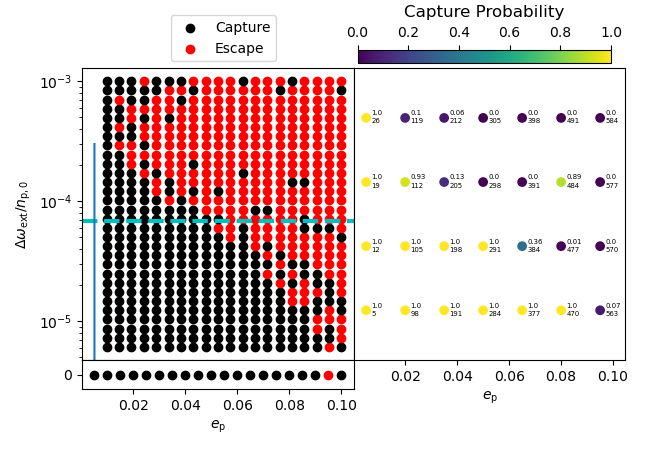

In [519]:
fig = plt.figure(figsize=(6.5,4.5)) 
gs = fig.add_gridspec(2, 2,height_ratios=[10,1]) 
ax1 = fig.add_subplot(gs[0, 0]) 
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[0, 1])

leg1 = False
leg2 = False
for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if nRatio > 0.8:
        if not leg1:
            leg1 = True
            ax1.scatter(params[1],params[2]-params[3],c="r",label="Escape")
        else:
            ax1.scatter(params[1],params[2]-params[3],c="r")
            #ax1.text(params[1],params[2]-params[3],params[0])
    else:
        if not leg2:
            leg2 = True
            ax1.scatter(params[1],params[2]-params[3],c="k",label="Capture")
        else:
            ax1.scatter(params[1],params[2]-params[3],c="k")
            #ax1.text(params[1],params[2]-params[3],params[0])
    #ax1.text(params[1],params[2]-params[3],f"{ind}")
#ax1.scatter(epsingle,Dpomsingle,c="c",marker="x")
ax1.set_yscale("log")#,linthresh=5e-6,linscale=0.05)
ax1.set_xticks([])
ax1.set_ylabel(r"$\Delta\omega_{\rm ext}/n_{\rm p,0}$")
ax1.axhline(y=DPOM_GPS,c="c",ls="--",lw=3)
ax1.legend(bbox_to_anchor=[0.3,1])

for ind, result in enumerate(results):
    params = jobs[ind]
    nRatio = results[ind].y[0,-1]/npy.exp(-results[ind].t[-1]/TMVAL)
    if params[2]-params[3] == 0:
        if nRatio > 0.8:
            ax2.scatter(params[1],params[2]-params[3],c="r")
        else:
            ax2.scatter(params[1],params[2]-params[3],c="k")
        #ax2.text(params[1],params[2]-params[3],f"{ind}")
ax2.set_yticks([0])
ax2.set_xlabel(r"$e_{\rm p}$")
#ax2.scatter(epsingle[2],Dpomsingle[2],c="c",marker="x")


cs = ax3.scatter(eplist, Domextlist,c=outcomes)
cb_ax = fig.add_axes([0.55,0.86,.39,.03])
fig.colorbar(cs,orientation='horizontal',cax=cb_ax)
cb_ax.xaxis.set_ticks_position('top')
cb_ax.set_title(r"Capture Probability")
for i, outcome in enumerate(outcomes):
    ax3.text(eplist[i]+0.002, Domextlist[i]*1.05,f"{outcome}",size=5)
    ax3.text(eplist[i]+0.002, Domextlist[i]*0.9,f"{indlist[i]}",size=5)

ax3.set_xlim(ax2.get_xlim())

ax3.set_yscale("log")
ax3.set_ylim(ax1.get_ylim())
ax3.set_yticks([])
ax3.set_yticks([],minor=True)
ax3.set_xlabel(r"$e_{\rm p}$")

fig.tight_layout()
fig.subplots_adjust(wspace=0,hspace=0)

In [52]:
291, 298

In [53]:
jobs[279]

In [54]:
fig.savefig("/Users/jtlaune/Desktop/grid.svg")

# Individual runs

In [55]:
TMVAL = 2*npy.pi*1e6
with open("singles_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [56]:
for job in jobs:
    print(job)

(119, 0.02, 0.0008094493062303981, 0.00031427515605210037)
(105, 0.02, 6.91199552465178e-05, 2.6836374500802313e-05)
(305, 0.049999999999999996, 0.0008094493062303981, 0.00031427515605210037)
(291, 0.049999999999999996, 6.91199552465178e-05, 2.6836374500802313e-05)
(491, 0.08, 0.0008094493062303981, 0.00031427515605210037)
(477, 0.08, 6.91199552465178e-05, 2.6836374500802313e-05)
(12, 0.005, 6.91199552465178e-05, 2.6836374500802313e-05)
(198, 0.034999999999999996, 6.91199552465178e-05, 2.6836374500802313e-05)
(384, 0.065, 6.91199552465178e-05, 2.6836374500802313e-05)
(570, 0.095, 6.91199552465178e-05, 2.6836374500802313e-05)
(26, 0.005, 0.0008094493062303981, 0.00031427515605210037)
(212, 0.034999999999999996, 0.0008094493062303981, 0.00031427515605210037)
(398, 0.065, 0.0008094493062303981, 0.00031427515605210037)
(584, 0.095, 0.0008094493062303981, 0.00031427515605210037)
(5, 0.005, 2.0198091944061386e-05, 7.842070465457619e-06)
(98, 0.02, 2.0198091944061386e-05, 7.842070465457619e-0

In [57]:
def moving_average(u, t, T):
    dt = npy.diff(t)[0]
    NT = int(T/dt)
    NS = npy.ones(NT)/NT
    out = npy.apply_along_axis(npy.convolve, axis=0, arr=u, v=NS, mode='same')
    return(out)

In [58]:
def plot(ind, fig, axes, color, t1, t2):
    t_ind1 = 0
    t_ind2 = -1
    t_ind1 = npy.where(results[ind].t > t1)[0][0]
    t_ind2 = npy.where(results[ind].t > t2)[0][0]

    tint = results[ind].t[t_ind1:t_ind2]
    nint = results[ind].y[0, t_ind1:t_ind2]
    npint = npy.exp(-results[ind].t[t_ind1:t_ind2] / TMVAL)
    eint = results[ind].y[1, t_ind1:t_ind2]
    pomint = results[ind].y[2, t_ind1:t_ind2]
    thpint = results[ind].y[3, t_ind1:t_ind2]
    alphaint = (nint / npint) ** (2.0 / 3)
    bint = 1.8956507412695471
    mupint = 5e-5
    ompint = jobs[ind][2]
    omint = jobs[ind][3]
    aint = nint**(2./3)

    print(jobs[ind])
    ax = axes[0]
    ax.set_ylabel(r"$n/n_{\rm p}$")
    ax.scatter(
        tint,
        nint / npint,
        #aint,
        s=0.01,
        c=color,
    )
    #ax.scatter(
    #    tint,
    #    nint*aint**2*(1-0.5*(2+1)*eint**2),
    #    s=0.01,
    #    c="c",
    #)

    ax = axes[1]
    ax.set_ylabel(r"$\theta$")
    ax.scatter(
        tint,
        (thpint + ompint * tint - pomint) % (2 * npy.pi),
        s=0.01,
        c=color,
    )

    ax = axes[2]
    ax.set_ylabel(r"$\theta_{\rm p}$")
    ax.scatter(
        tint,
        thpint % (2 * npy.pi),
        s=0.01,
        c=color,
    )

    #ax = axes[3]
    #ax.set_ylabel(r"$\varpi$")
    #ax.scatter(
    #    tint,
    #    pomint % (2 * npy.pi),
    #    s=0.01,
    #    c=color,
    #)

    ax = axes[3]
    ax.set_ylabel(r"$\varpi_{\rm p}-\varpi$")
    ax.scatter(
        tint,
        (ompint * tint - pomint) % (2 * npy.pi),
        s=0.01,
        c=color,
    )
    #ax.axhline(y=npy.pi,c="c",ls="--")
    #ax.axhline(y=3*npy.pi/2,c="m",ls="--")
    #ax.axhline(y=npy.pi/2,c="m",ls="--")

    ax = axes[4]
    ax.set_ylabel(r"$e$")
    ax.scatter(
        tint,
        eint,
        s=0.01,
        c=color,
    )
    # lims = ax.get_ylim()
    # ax.plot(tint, -mupint*bint*nint*alphaint**(-1)/(3*nint-2*npint-omint))
    # ax.set_ylim(lims)

    for ax in axes:
        ax.set_xlim((tint[0], tint[-1]))
    for ax in axes[1:4]:
        ax.set_ylim((0, 2 * npy.pi))
    for ax in axes[:-1]:
        ax.set_xticklabels([])
    axes[-1].set_xlabel(r"$n_{\rm p}t$")
    axes[4].set_ylim(bottom=0)
    fig.subplots_adjust(hspace=0.1)

(491, 0.08, 0.0008094493062303981, 0.00031427515605210037)


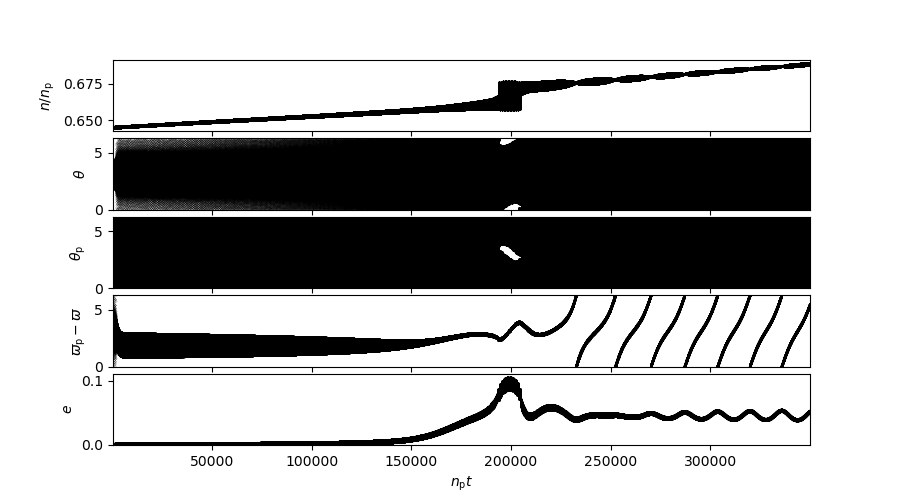

In [59]:
# Main series of increasing Domext: 298, 291, 279
# Both angles transient libration: 491
ind = 491
jobind = 0
for job in jobs:
    if job[0] == ind:
        break
    jobind += 1
fig, axes = plt.subplots(5, figsize=(9, 5))
plot(jobind, fig, axes, "k",0,3.5e5)
#fig.savefig(f"{jobs[jobind]}.png",dpi=200,bbox_inches="tight")

- Could it be related to $\varpi_{\rm p} - \varpi$?
- Try finding solutions where $\frac{d}{dt}(\varpi_p-\varpi)=0$. 
    - Does it drive the value of $e$ up somehow? 
    - Lead to large librations and passage through resonance? 
    - Look into balance of energy from Tremaine book?

## Zoomed in (time) plots of non-capture

(491, 0.08, 0.0008094493062303981, 0.00031427515605210037)


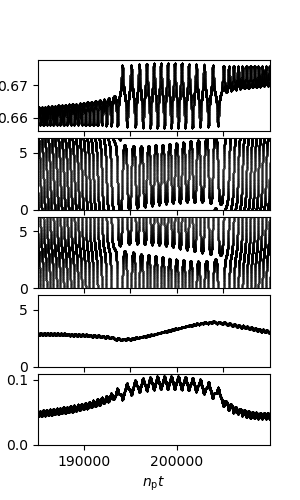

In [60]:
ind =  491 #298
jobind = 0
for job in jobs:
    if job[0] == ind:
        break
    jobind += 1
fig, axes = plt.subplots(5, figsize=(3, 5))
plot(jobind, fig, axes, "k",1.85e5,2.1e5)
for ax in axes: ax.set_ylabel("")
axes[4].xaxis.set_major_locator(mpl.ticker.MaxNLocator(3))
fig.savefig(f"zoomed-{jobs[jobind]}.png",dpi=200,bbox_inches="tight")

# One degree of freedom $\theta$

Throughout, I basically treat $\Gamma=\frac12\sqrt{GMa_0}e^2$ and $a_0$ is the SMA corresponding to $(j+1)n=jn_p$. There should be a slight difference in $a_0$ when things are precessing, but i don't think it impacts the dynamics beyond shifting the resonance center (i.e., its a second order effect everywhere else). Should probably incorporate it somehow into the definition of $k$.. or maybe do everything for $\omega=0$ and then shift the separatrix up in $n-\theta$ space?

### $H$ and $a_0$

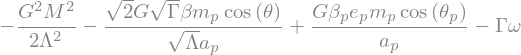

In [181]:
H

Define $a_0\equiv a_{\rm p}/\alpha_0$

Is this definition square with an apsidally precessing resonance?

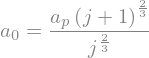

In [61]:
a0 = symbols(r"a_0", positive=True)
display(Eq(a0, ap * ((j + 1) / j) ** Rational(2, 3)))

Suppose $\Lambda=\sqrt{GMa_0}$ in denominator of resonant term.

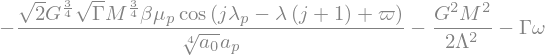

In [147]:
Hth = H.subs(
    {bp: 0, 
    th: (j + 1) * l - j * lp - pom, 
    ap * sqrt(Lam): ap * (G * M * a0)**Rational(1,4),
    mp: M*mup}
)
Hth

### Generating function 1

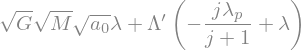

In [148]:
L1, l1 = symbols(r"\Lambda' \lambda'")
S1 = L1 * (l - j * lp / (j + 1)) + l * sqrt(G * M * a0)
display(S1)

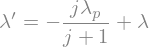

In [149]:
display(Eq(l1,S1.diff(L1)))
display(Eq(Lam,S1.diff(l)))

This way, $\Lambda'$ is small near resonance.

Time dependence of generating function $S'$.

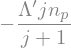

In [150]:
display(S1.diff(lp)*np)

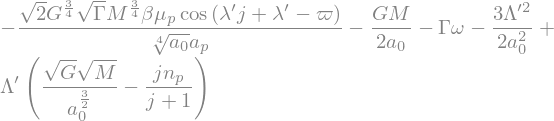

In [151]:
Hth1 = Hth.subs({l: solve(l1 - S1.diff(L1), l)[0], Lam: S1.diff(l)}) + S1.diff(lp) * np
Hth1 = Hth1.taylor_term(0, L1) + Hth1.taylor_term(1, L1) + Hth1.taylor_term(2, L1)
Hth1

We see the terms linear in $L'$ cancel out.

But maybe they don't if there is apsidal precession?

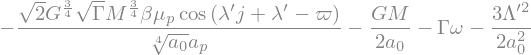

In [152]:
Hth1 = Hth1.subs({np:(j+1)/j*sqrt((G*M)/a0**3)})
Hth1

### Generating function 2

In [153]:
L2, l2, G2 = symbols(r"\Lambda'' \lambda'' \Gamma''")
S2 = G2 * ((j + 1) * l1 - pom) + L2 * l1
display(S2)

In [154]:
display(Eq(Gam, -S2.diff(pom)))
display(Eq(L1, S2.diff(l1)))
display(Eq(th, S2.diff(G2)))
display(Eq(l2, S2.diff(L2)))

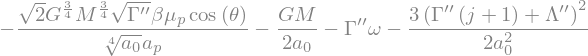

In [155]:
Hth2 = Hth1.subs(
    {
        Gam: -S2.diff(pom),
        L1: S2.diff(l1),
        pom: solve(th - S2.diff(G2), pom)[0],
    }
)
Hth2

### Conserved quantity

$\Lambda''$ is a conserved quantity.

In [156]:
Eq(L2, solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j+1))

In [157]:
da = symbols(r"\delta_a")
display(Eq(a,a0*(1+da)))

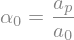

In [158]:
alpha0 = symbols(r"\alpha_0", positive=True)
display(Eq(alpha0,ap/a0))

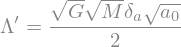

In [159]:
display(Eq(L1,Lam-sqrt(G*M*a0)))
display(Eq(L1,(sqrt(G*M*a0*(1+da))-sqrt(G*M*a0)).taylor_term(1,da)))

Here we assume $\Gamma''\approx\frac12\sqrt{GMa_0}e^2$ in the definition of $\Lambda''$ and $k$... is this reasonable?

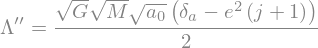

In [160]:
display(Eq(L2,
solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j + 1).subs(
    {
        G2: Rational(1, 2) * sqrt(G * M * a0) * e**2,
        L1: (sqrt(G*M*a0*(1+da))-sqrt(G*M*a0)).taylor_term(1,da),
    }
).collect(Rational(1,2)*sqrt(G*M*a0))
))

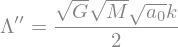

In [161]:
display(Eq(L2, Rational(1,2)*sqrt(G*M*a0)*k))

In [162]:

display(Eq(k,
solve(L1 - S2.diff(l1), L2)[0].collect(G2).collect(j + 1).subs(
    {
        G2: Rational(1, 2) * sqrt(G * M * a0) * e**2,
        L1: (sqrt(G*M*a0*(1+da))-sqrt(G*M*a0)).taylor_term(1,da),
    }
).collect(Rational(1,2)*sqrt(G*M*a0))/(Rational(1,2)*sqrt(G*M*a0))
))

### Final Hamiltonian

Separate the Hamiltonian into "radial" and resonant parts.

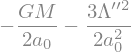

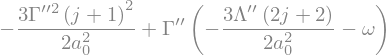

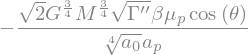

In [163]:
Hth2rad = Hth2.subs({b:0})
Hth2const = Hth2rad.taylor_term(0,G2)
Hth2res = Hth2-Hth2rad
Hth2rad = Hth2rad.taylor_term(1,G2) + Hth2rad.taylor_term(2,G2)
display(Hth2const)
display(Hth2rad)
display(Hth2res)

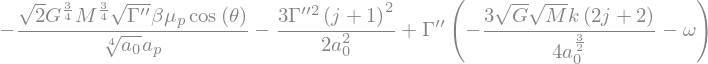

In [168]:
Hthf = (Hth2rad + Hth2res).subs(
    {
        L2: Rational(1, 2) * sqrt(G * M * a0) * k,
        #sqrt(G * M / a0): sqrt(alpha0) * np * ap,
        #k:k/sqrt(G*M)*a0**Rational(3,2)*j*np*2/(2*j+2)
    }
)
Hthf

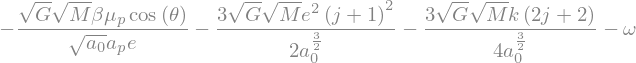

In [183]:
Hthf.diff(G2)

Now set the $\Gamma''=\frac12\sqrt{GMa_0}e^2$... Is this reasonable?

In [188]:
def term_expand(expr):
    run = 0
    for arg in expr.args:
        run += arg.expand()
    return(run)

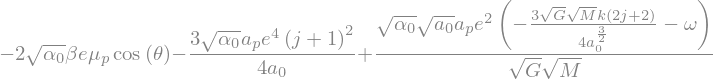

In [203]:
term_multiply(Hthf.subs({G2: Rational(1, 2)*sqrt(G*M*a0) * e**2}), 1/(G*M/ap/sqrt(alpha0)/2))

### Scaled Hamiltonian and separatrix

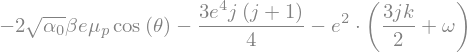

In [204]:
H_scaled = -Rational(3,4)*j*(j+1)*e**4 - (Rational(3,2)*j*k+om)*e**2 - 2*sqrt(alpha0)*b*mup*e*cos(th)
H_scaled

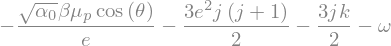

In [206]:
thdot = term_multiply(H_scaled.diff(e),1/(2*e))
thdot

In [215]:
alpha0val = (2/3) ** (2.0 / 3)
alpha0val

Assume $\omega=0$ in calculating crit value of $k$... again only considering $\omega$ as it shifts entire separatrix pattern up in $n-a$ space

Must solve this equation to find stable values of $e$ as a function of $k$... first finding critical value of $k$

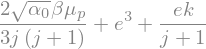

In [287]:
term_multiply(thdot, -e / (3 * j * (j + 1) / 2)).subs(th, 0).subs(om,0)

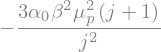

In [274]:
k_crit3 = term_multiply(fraction(discriminant(term_multiply(thdot, -e / (3 * j * (j + 1) / 2)).subs(th, 0), e).subs(
    {om: 0}
))[0],1/108/j**3).subs({k:0}).simplify().subs(3.,3).collect(j+1)
k_crit3

In [275]:
discriminant(term_multiply(thdot, -e / (3 * j * (j + 1) / 2)).subs(th, 0), e).subs(
    {b: 1.8956507412695471, j: 2, alpha0: alpha0val,om:0}
)*-27/4

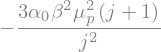

In [276]:
k_crit3

In [277]:
-(-k_crit3.subs(
    {b: 1.8956507412695471, j: 2, alpha0: alpha0val,om:0,mup:1}
))**(1/3)

Stable is at $\theta=\pi$

Assume $\omega=0$ in calculation of separatrix

this is the critical values of $e$ for $\mu_p=5\times10^5$ when the separatrix appears

In [309]:
term_multiply(thdot.subs({k:-1.83415062648441*mup**Rational(2,3),th:pi,om:0}),e/(j*(j+1)*3/2)).subs(
    {b: 1.8956507412695471, j: 2, alpha0: alpha0val,om:0,mup:5e-5}
)

In [317]:
roots(term_multiply(thdot.subs({k:-1.83415062648441*mup**Rational(2,3),th:pi,om:0}),e/(j*(j+1)*3/2)).subs(
    {b: 1.8956507412695471, j: 2, alpha0: alpha0val,om:0,mup:5e-5}
),e)

Positive is $e_0$ stable, negative is $e_{\rm sep}$

### Plotting the separatrices

    bp: 1.5455341716765871,

In [529]:
TMVAL = 2*npy.pi*1e6
with open("ep0_mup5e-5_tm2pi1e6_n1.55_omalpha0val3.5.pkl", "rb") as f:
    jobs, results = pickle.load(f)

In [530]:
jobs

In [536]:
def func(t):
    if t > 2 * npy.pi * 1.5e5:
        npval = npy.exp(-2 * npy.pi * 1.5e5 / TMVAL)
    else:
        npval = npy.exp(-t / TMVAL)
    return npval

In [575]:
ind=1
#t1 = 2.4e5
#t2 = 2.6e5
t_ind1 = 0
t_ind2 = -1
#t_ind1 = npy.where(results[ind].t > t1)[0][0]
#t_ind2 = npy.where(results[ind].t > t2)[0][0]
tint = results[ind].t[t_ind1:t_ind2]
nint = results[ind].y[0, t_ind1:t_ind2]
npint = npy.array([func(tval) for tval in tint])
eint = results[ind].y[1, t_ind1:t_ind2]
pomint = results[ind].y[2, t_ind1:t_ind2]
thpint = results[ind].y[3, t_ind1:t_ind2]
ompint = jobs[ind][2]
omint = jobs[ind][3]
alphaint = (nint / npint) ** (2.0 / 3)
bint = 1.8956507412695471
aint = nint**(-2./3)

In [576]:
#t1 = 2.46874e5#2.2e5
#t2 = 2.47005e5
#no_prec = [(thpint + ompint*tint - pomint) %(2*npy.pi), aint]

#t1 = 2.56917e5
#t2 = 2.57045e5
#prec = [(thpint + ompint*tint - pomint) %(2*npy.pi), aint]

In [577]:
-1.83*5e-5**(2./3)

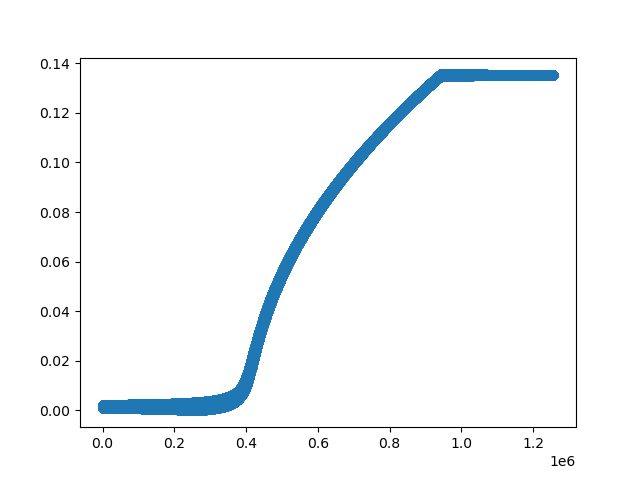

In [582]:
fig, ax = plt.subplots()
#ax.scatter(prec[0], prec[1])
#ax.scatter(no_prec[0], no_prec[1])
#ax.scatter((thpint + ompint*tint - pomint) %(2*npy.pi), aint, c=tint)
#ax.scatter(tint,(thpint + ompint*tint - pomint) %(2*npy.pi))
kint = aint/((npint*2/3)**(-2./3))-1-3*eint**2
daint = aint/((npint*2/3)**(-2./3))-1
#ax.scatter(tint,kint )#- npy.average(kint[-1000:]),s=0.01)
#ax.scatter(tint,daint - npy.average(daint[-1000:]),s=0.01)
ax.scatter(tint,eint)# - npy.average(daint[-1000:]),s=0.01)
#ax.scatter(tint,3*eint**2 - npy.average(3*eint[-1000:]**2),s=0.01)
#ax.set_ylim(0,2*npy.pi)
#ax.scatter(tint,results[1].y[0, t_ind1:t_ind2]-results[0].y[0, t_ind1:t_ind2],s=0.1)

In [478]:
jobs[1][3]/4

In [460]:
prec-no_prec

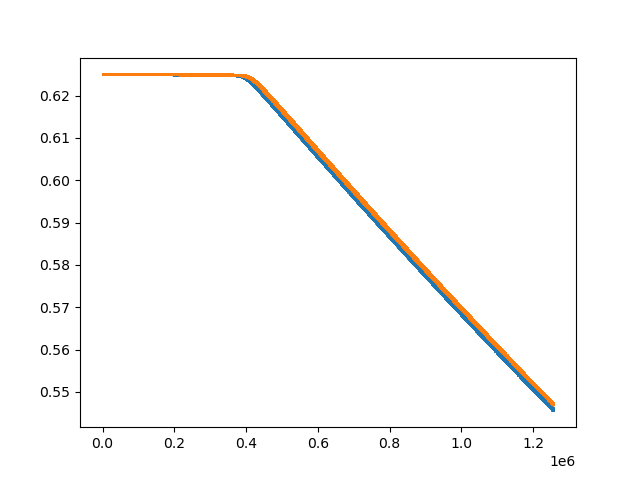

In [457]:
fig.show()